# Zillow Clustering Project 
- By Jeff Akins

### Project Goal: To determine the drivers of error in Zillow's Zestimates
The data provided is from Zillow and consists of all homes, and their attributes, listed and sold during 2017 within three southern California counties.

### Executive Summary:
Exploration of Zillow's data did not provide obvious drivers of Zestimate error. By clustering around the log error itself you can determine the top drivers for each cluster; however, creating linear regression models based on those features have not produced improved results thus far over a baseline prediction of logerror. I believe that there may be potential in clustering by location, but the fidelity would need to be at the neighborhood level to produce reasonable results; so far, I have not been able to zoom in to that level. Below is more details on some of the exploration and modeling results.

##### Imports:

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data Handling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

# Wrangle file to acquire and clean Zillow data
import wrangle_zillow as wr
import sklearn.preprocessing

# Explore file
import explore as ex
import explore_evaluate as ee
from sklearn.cluster import KMeans

# Models
import zillow_models as zm

## Acquire:
- The data was acquired form Codeup's MySQL server
- Homes with a value over $5M were excluded
- Homes over 8000 sqft were excluded
- The details of how the zillow data was acquired is in the **wrangle_zillow.py** file
- Here is a list of columns that were dropped due to a high number of nulls or due to information that was redundant or irrelevant to determining drivers of logerror:
    - parcelid
    - calculatedbathnbr
    - finishedsquarefeet12
    - fullbathcnt
    - heatingorsystemtypeid
    - propertycountylandusecode
    - propertylandusetypeid
    - propertyzoningdesc
    - censustractandblock
    - propertylandusedesc
    - buildingqualitytypeid
    - rawcensustractandblock
    - regionidcity
    - regionidcounty
    - regionidzip
    - unitcnt
    - assessmentyear
    - lotsizesquarefeet
    - roomcnt
    - structuretaxvaluedollarcnt
    - landtaxvaluedollarcnt
    - taxamount

In [2]:
zillow = wr.wrangle_zillow()
zillow.head(3)

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet    fips    latitude  \
0          3.5         4.0                        3100.0  6059.0  33634931.0   
1          1.0         2.0                        1465.0  6111.0  34449266.0   
2          2.0         3.0                        1243.0  6059.0  33886168.0   

     longitude  yearbuilt  taxvaluedollarcnt  logerror transactiondate  \
0 -117869207.0     1998.0          1023282.0  0.025595      2017-01-01   
1 -119281531.0     1967.0           464000.0  0.055619      2017-01-01   
2 -117823170.0     1962.0           564778.0  0.005383      2017-01-01   

  heatingorsystemdesc   county  
0                None   Orange  
1                None  Ventura  
2                None   Orange

In [3]:
zillow['abs_logerr'] = zillow.logerror.apply(lambda x: x if x >= 0 else -x)
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70910 entries, 0 to 77380
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   70910 non-null  float64
 1   bedroomcnt                    70910 non-null  float64
 2   calculatedfinishedsquarefeet  70910 non-null  float64
 3   fips                          70910 non-null  float64
 4   latitude                      70910 non-null  float64
 5   longitude                     70910 non-null  float64
 6   yearbuilt                     70910 non-null  float64
 7   taxvaluedollarcnt             70910 non-null  float64
 8   logerror                      70910 non-null  float64
 9   transactiondate               70910 non-null  object 
 10  heatingorsystemdesc           70910 non-null  object 
 11  county                        70910 non-null  object 
 12  abs_logerr                    70910 non-null  float64
dtypes

### Train, Validate, Test Split

In [4]:
train, validate, test = wr.train_validate_test_split(zillow)
print("train observations: ", train.size)
print("validate observations: ", validate.size)
print("test observations: ", test.size)

train observations:  553098
validate observations:  184366
test observations:  184366


## Explore:

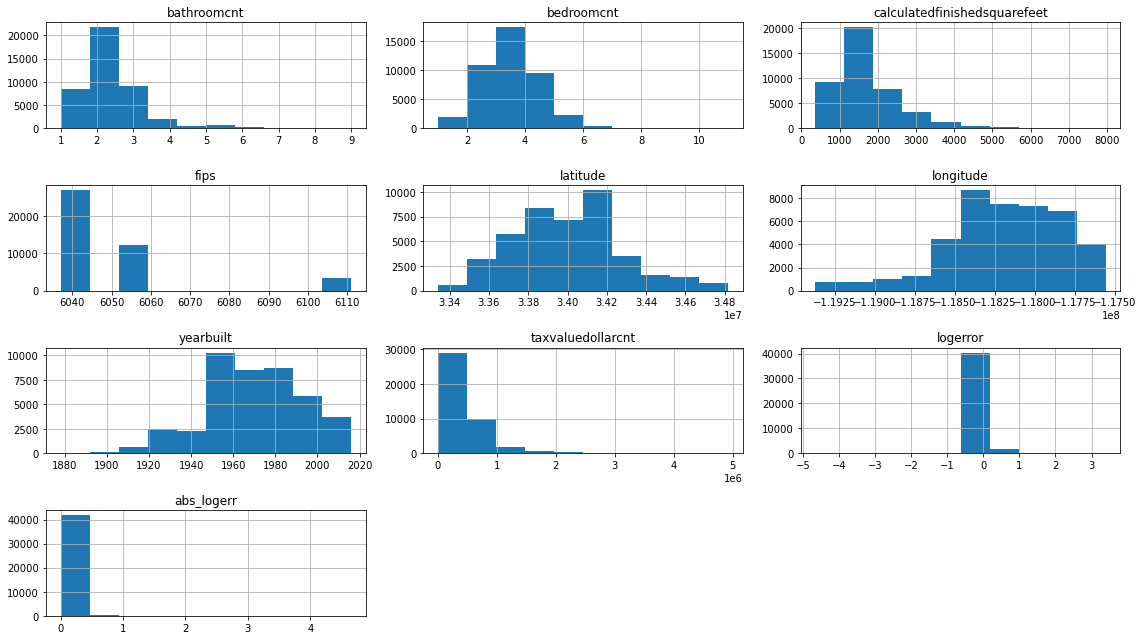

In [5]:
train.hist(figsize=(16,9))
plt.tight_layout()
plt.show()

##### Findings: Bedroom and Bathroom counts look normally distributed, all else is skewed. 

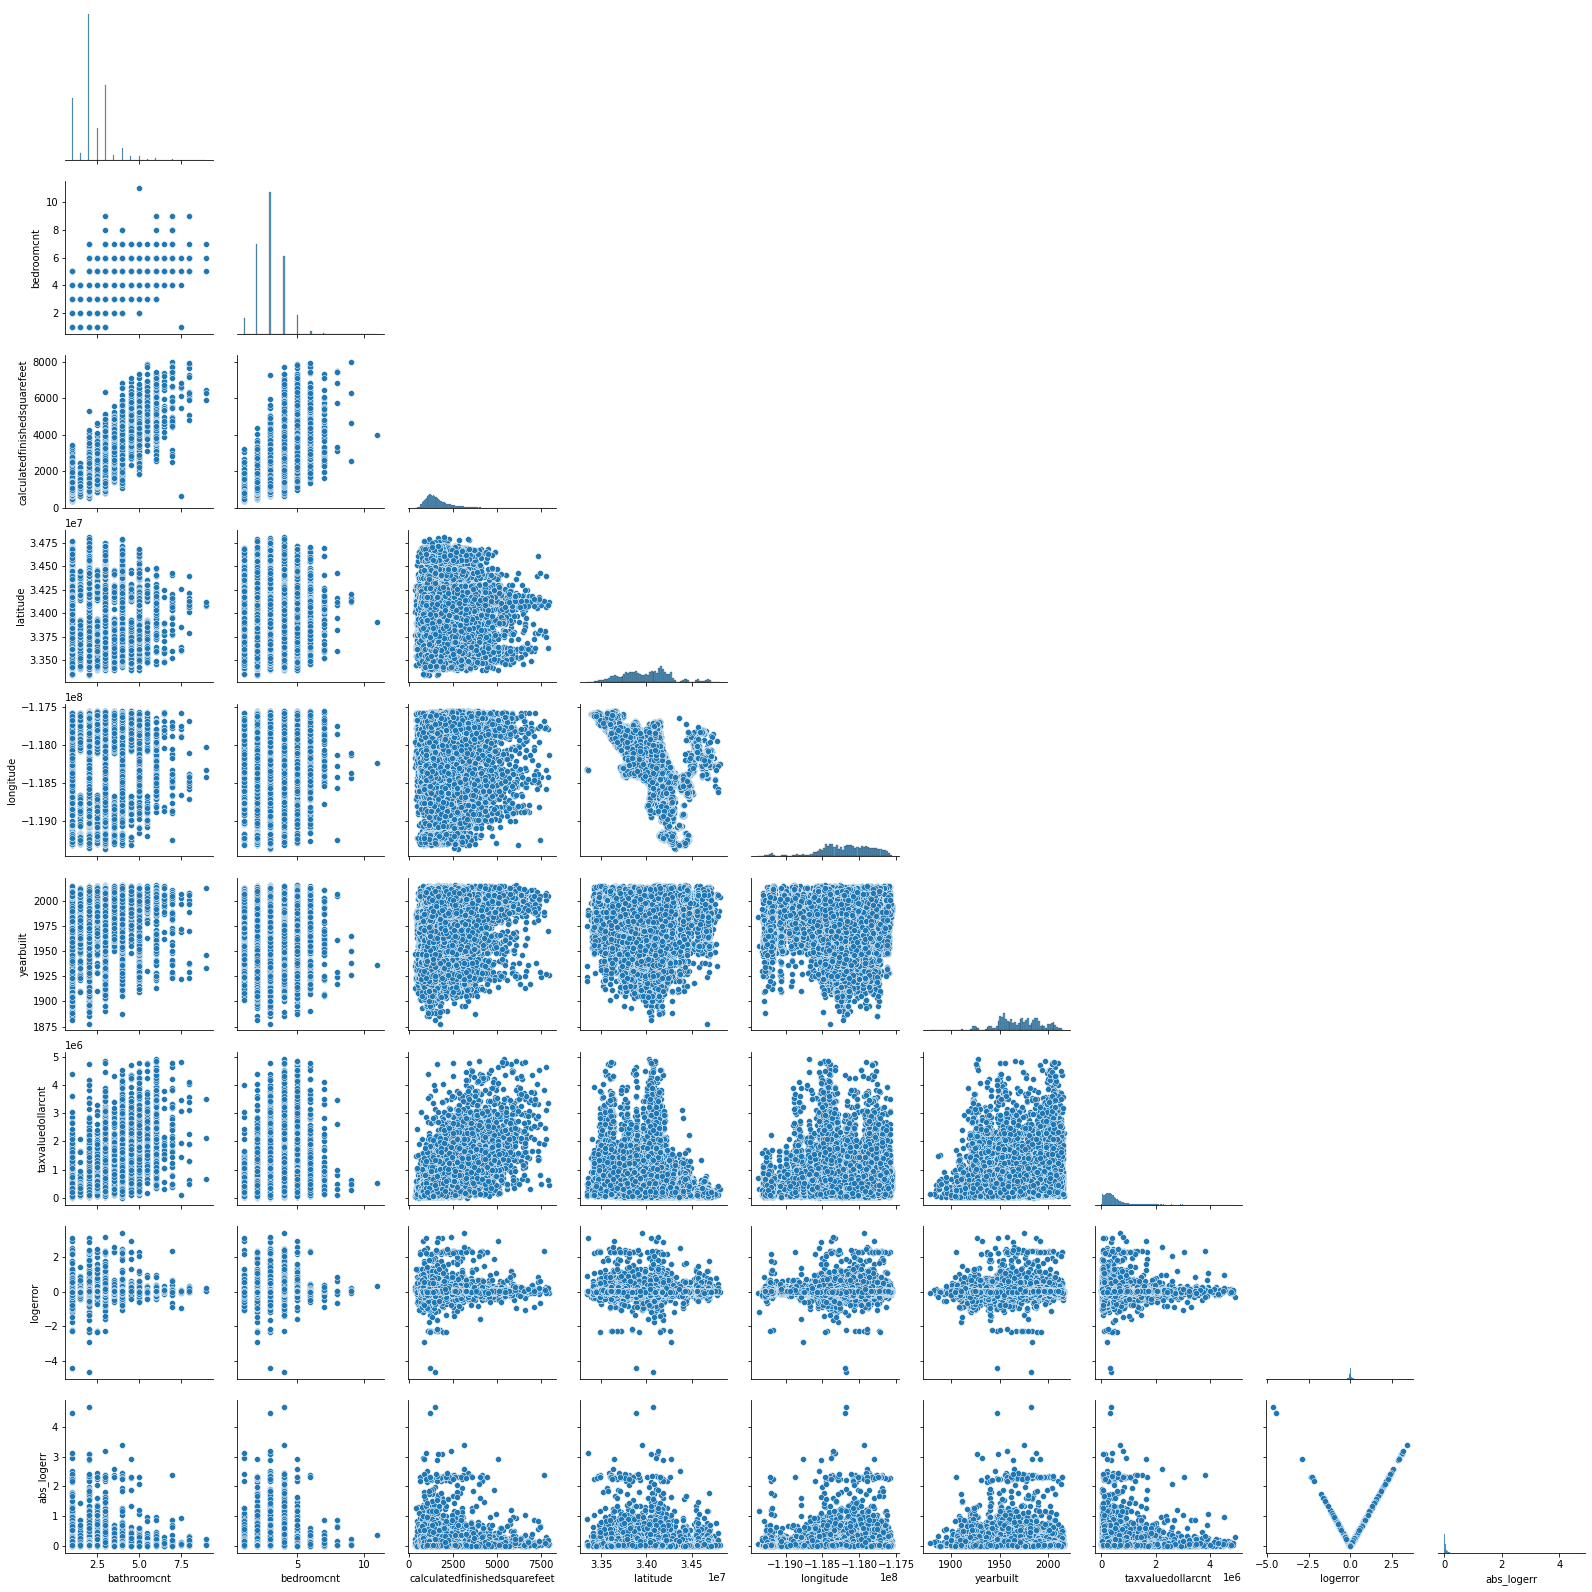

In [6]:
sns.pairplot(train.drop(columns='fips'), corner=True)
plt.show()

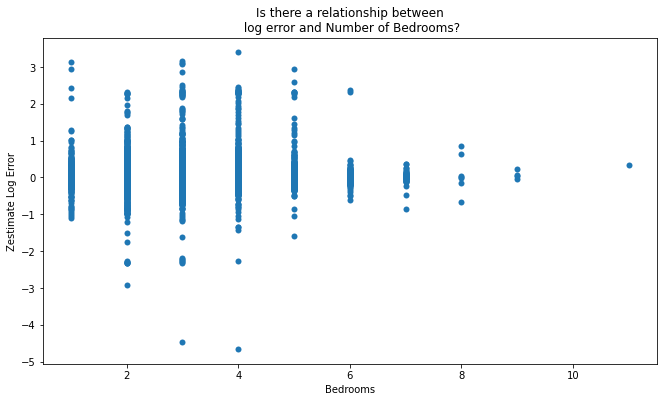

In [7]:
# Plot of log error vs number of bedrooms
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="bedroomcnt", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship between\n log error and Number of Bedrooms?')
plt.xlabel('Bedrooms')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

In [136]:
# H0: There is no linear correlation between number of bedrooms and logerror
# Ha: There is a linear correlation
r, p = stats.pearsonr(train.bedroomcnt, train.logerror)
print('R: ', r)
print('p: ', p)
print('p<0.05, Therefore, reject H0')

R:  0.03794774065450858
p:  4.8806496567403126e-15
p<0.05, Therefore, reject H0


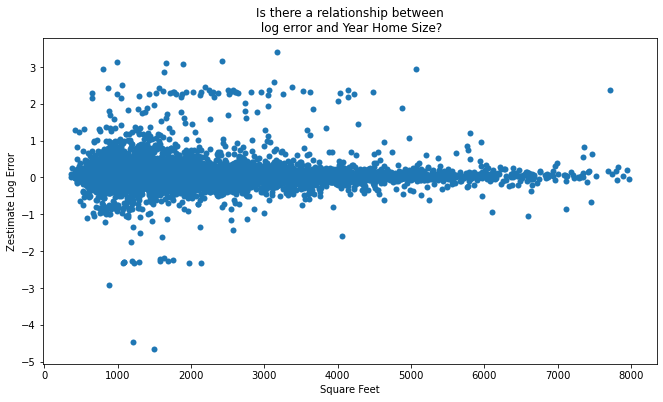

In [8]:
# Plot of log error vs square feet
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="calculatedfinishedsquarefeet", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship between\n log error and Year Home Size?')
plt.xlabel('Square Feet')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

In [137]:
# H0: There is no linear correlation between square feet and logerror
# Ha: There is a linear correlation
r, p = stats.pearsonr(train.calculatedfinishedsquarefeet, train.logerror)
print('R: ', r)
print('p: ', p)
print('p<0.05, Therefore, reject H0')

R:  0.05041411972072864
p:  2.3508134856820896e-25
p<0.05, Therefore, reject H0


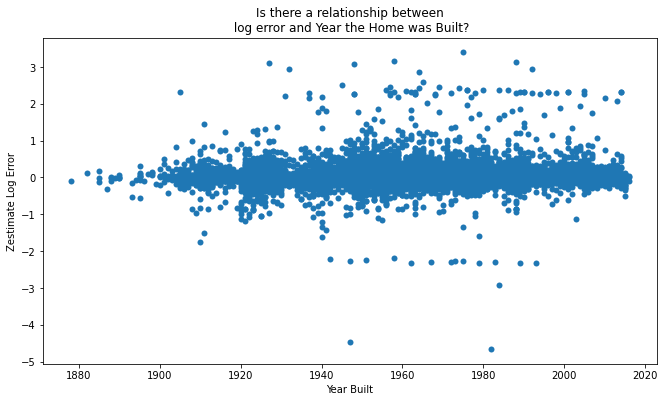

In [9]:
# Plot of log error vs year built
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="yearbuilt", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship between\n log error and Year the Home was Built?')
plt.xlabel('Year Built')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

In [138]:
# H0: There is no linear correlation between year built and logerror
# Ha: There is a linear correlation
r, p = stats.pearsonr(train.yearbuilt, train.logerror)
print('R: ', r)
print('p: ', p)
print('p<0.05, Therefore, reject H0')

R:  0.018949568176820638
p:  9.271609180831697e-05
p<0.05, Therefore, reject H0


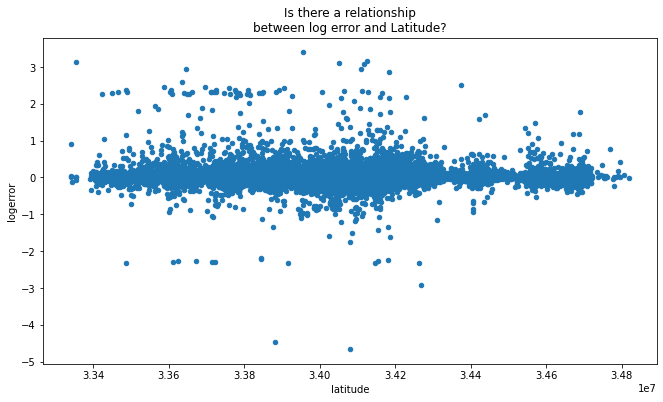

In [10]:
train.plot.scatter(
    x="latitude",
    y="logerror",
    title='Is there a relationship\nbetween log error and Latitude?',
    figsize=(11, 6)
)
plt.show()

In [143]:
# H0: There is no linear correlation between latitude and logerror
# Ha: There is a linear correlation
r, p = stats.pearsonr(train.latitude, train.logerror)
print('R: ', r)
print('p: ', p)
print('p<0.05, Therefore, reject H0')

R:  -0.015269069818695895
p:  0.001634977843348947
p<0.05, Therefore, reject H0


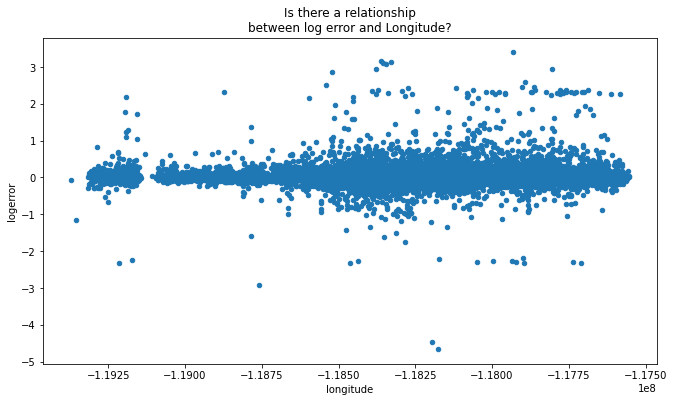

In [11]:
train.plot.scatter(
    x="longitude",
    y="logerror",
    title='Is there a relationship\nbetween log error and Longitude?',
    figsize=(11, 6),
)
plt.show()

In [144]:
# H0: There is no linear correlation between longitude and logerror
# Ha: There is a linear correlation
r, p = stats.pearsonr(train.longitude, train.logerror)
print('R: ', r)
print('p: ', p)
print('p<0.05, Therefore, reject H0')

R:  0.015360880424764078
p:  0.0015320995866740135
p<0.05, Therefore, reject H0


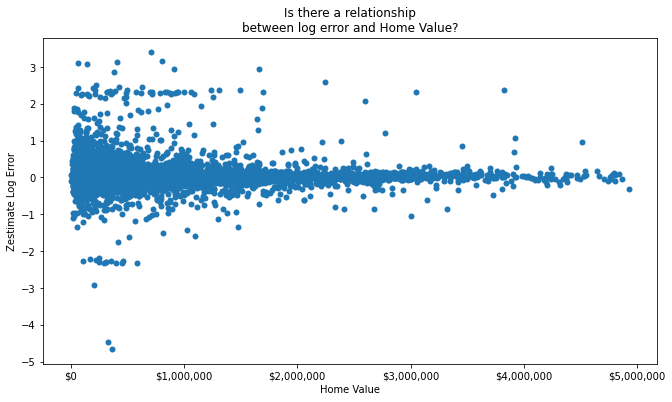

In [12]:
# Plot of log error vs home value
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="taxvaluedollarcnt", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train, ax=ax)
plt.title('Is there a relationship\nbetween log error and Home Value?')
plt.xlabel('Home Value')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('${:,.0f}'.format) 

In [145]:
# H0: There is no linear correlation between home value and logerror
# Ha: There is a linear correlation
r, p = stats.pearsonr(train.taxvaluedollarcnt, train.logerror)
print('R: ', r)
print('p: ', p)
print('p<0.05, Therefore, reject H0')

R:  0.013895973247407684
p:  0.004152580477502153
p<0.05, Therefore, reject H0


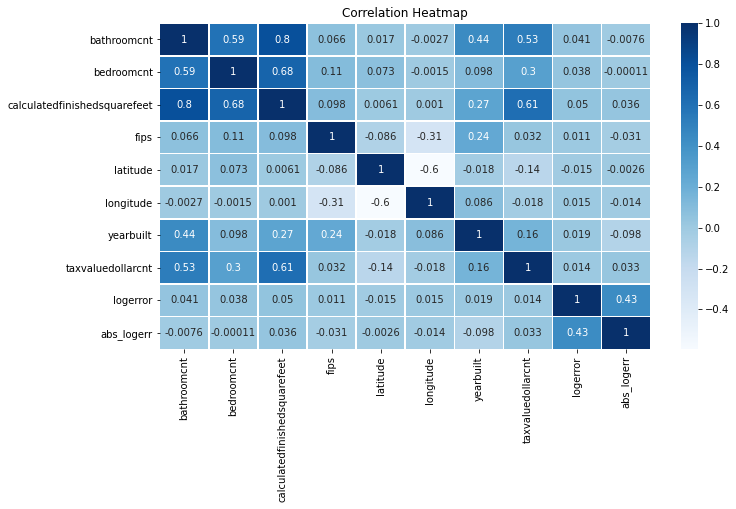

In [13]:
plt.figure(figsize=(11,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True, linewidth=0.5)
plt.title('Correlation Heatmap')
plt.show()

##### Findings: There are weak correlations amongst all continuous features and log error. 

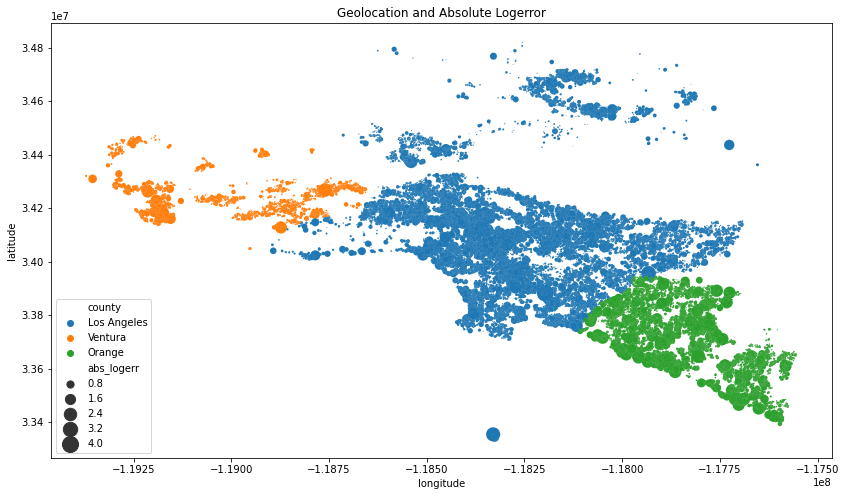

In [14]:
# Plot of error using lat/long
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='county', size='abs_logerr', sizes=(0,300), data=train)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

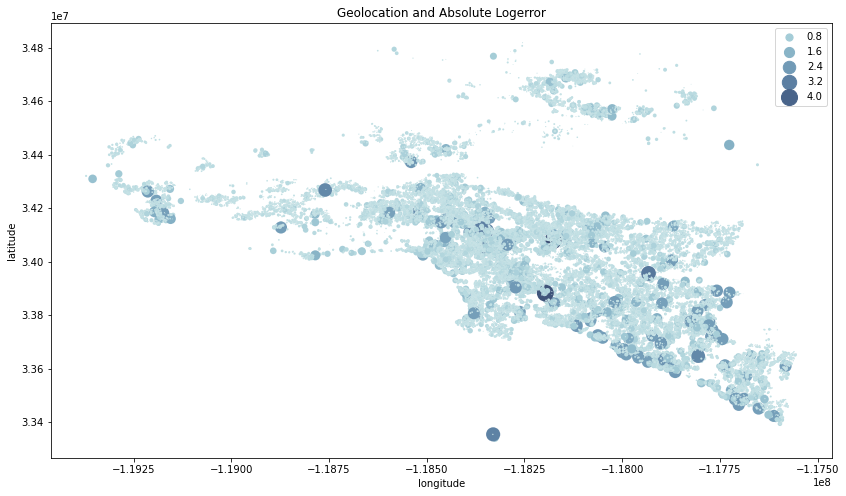

In [15]:
# Plot of error using lat/long
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='abs_logerr', palette="ch:r=-.2,d=.3", size='abs_logerr', sizes=(0,300), data=train)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

##### Takeaways:
- There seems to be bands of clusters in log error vs above categories
- Lat Long seems to be the most promising to explore via clustering
- Then potentially sqft and beadroom/bathroom count

### Scaling
- To prepare for initial modeling

In [17]:
# Scale the datasets
column = ['fips', 'transactiondate', 'heatingorsystemdesc', 'county', ]
scaler = sklearn.preprocessing.MinMaxScaler()
cols = train.drop(columns=column).columns.tolist()

# .copy() makes a proper copy
# this is an alternative to wrapping the scaled numpy array in a pd.Dataframe()
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()

# apply our scaler (fit only on train!)
train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.transform(validate[cols])
test_scaled[cols] = scaler.transform(test[cols])

train_scaled = train_scaled.drop(columns=column)
validate_scaled = validate_scaled.drop(columns=column)
test_scaled = test_scaled.drop(columns=column)

In [18]:
train_scaled.head(2)

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  
28420   0.502856   0.826087           0.028647  0.580490     0.00376  
66765   0.594425   0.224638           0.027425  0.585111     0.01175

## Initial Regression Models

In [19]:
# Function to split train, validate, test into their X, y components:
X_train, y_train, X_validate, y_validate, X_test, y_test = zm.zillow_xy(train_scaled.drop(columns='abs_logerr'), 
                                                                        validate_scaled.drop(columns='abs_logerr'), 
                                                                        test_scaled.drop(columns='abs_logerr'))

In [20]:
# Function to compare model performance:
compare = zm.model_compare(X_train, y_train, X_validate, y_validate)
compare

model  RMSE Train  RMSE Validate  r^2 Validate
0  Baseline (mean)    0.020509       0.020839      0.000000
1    OLS Regressor    0.020474       0.020842     -0.000075
2   Lasso: Alpha 1    0.020509       0.020842      0.000000
3       GLM Normal    0.020484       0.020843     -0.000168
4      GLM Poisson    0.020482       0.020844     -0.000306
5  Polynomial 2deg    0.020440       0.020835      0.000690
6  Polynomial 3deg    0.020383       0.020907     -0.006295

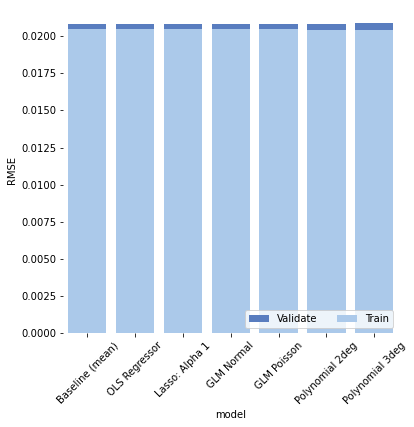

In [21]:
# Visual representation of the above chart:
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes("muted")
sns.barplot(x="model", y="RMSE Validate", data=compare,
            label="Validate", color="b")
sns.set_color_codes("pastel")
sns.barplot(x="model", y="RMSE Train", data=compare,
            label="Train", color="b")
ax.legend(ncol=2, loc="lower right", frameon=True)
plt.ylabel('RMSE')
plt.xticks(rotation = 45)
sns.despine(left=True, bottom=True)

In [22]:
#Recursive Feature Elimination Ranking
ee.rfe_output(X_train, y_train)

Var  Rank
0                   bathroomcnt     7
1                    bedroomcnt     4
2  calculatedfinishedsquarefeet     1
3                      latitude     3
4                     longitude     6
5                     yearbuilt     5
6             taxvaluedollarcnt     2

##### Findings: 
- When passed all features there is not much of a difference between model performance in predicting Zestimate logerror
- However, this provides a baseline for comparing potential clustered models

## Clustering: K-Means

#### Clustering by Latitude, Logitude and Absolute Error

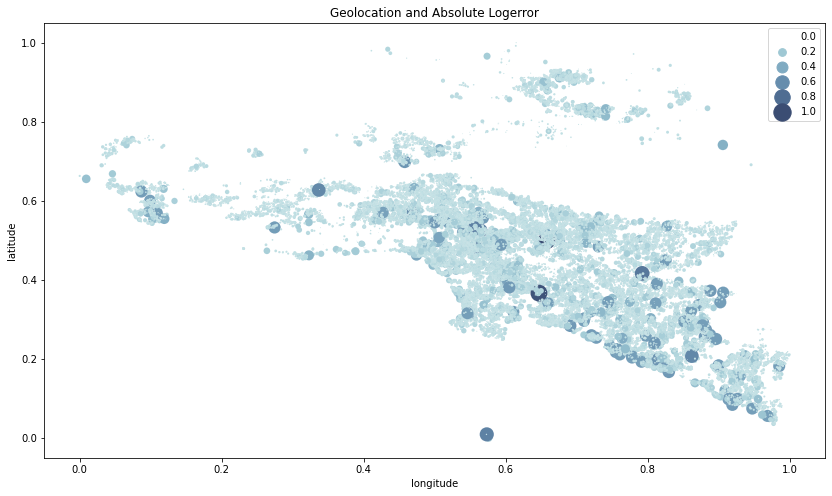

In [23]:
# Plot of error using lat/long
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='abs_logerr', palette="ch:r=-.2,d=.3", size='abs_logerr', sizes=(0,300), data=train_scaled)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

In [24]:
# Function to determine the best k value for clustering
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

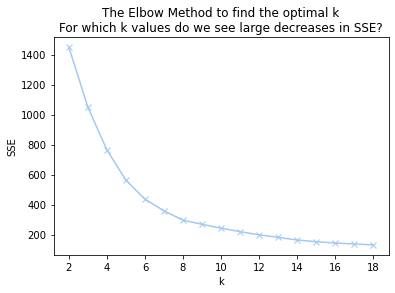

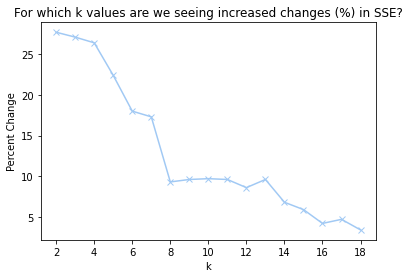

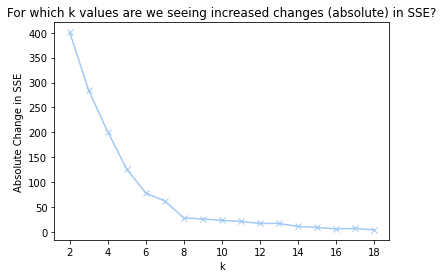

k          sse  delta  pct_delta
0    2  1448.741218  401.0       27.7
1    3  1047.296895  284.0       27.1
2    4   762.970152  201.0       26.4
3    5   561.777486  126.0       22.4
4    6   435.725439   78.0       18.0
5    7   357.511389   62.0       17.3
6    8   295.793538   28.0        9.3
7    9   268.194242   26.0        9.6
8   10   242.387667   23.0        9.7
9   11   218.988640   21.0        9.6
10  12   198.062237   17.0        8.6
11  13   181.052030   17.0        9.6
12  14   163.592716   11.0        6.8
13  15   152.412545    9.0        5.9
14  16   143.407778    6.0        4.2
15  17   137.328211    7.0        4.7
16  18   130.812849    4.0        3.4

In [25]:
cluster_vars = ['latitude', 'longitude', 'abs_logerr']
cluster_name = 'latlong_err_cluster'
k_range = range(2,20)

k_comparisons_df = find_k(train_scaled, cluster_vars, k_range)
k_comparisons_df

In [26]:
# Fit K-Means (just on train, again!)
X = train_scaled[['latitude', 'longitude', 'abs_logerr']]
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)

train_scaled['latlong_err_cluster'] = kmeans.predict(X)
train_scaled.head()

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   
25714        0.125         0.2                      0.096715  0.564669   
21340        0.125         0.3                      0.193824  0.626706   
46673        0.000         0.2                      0.101971  0.326450   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490    0.003760   
66765   0.594425   0.224638           0.027425  0.585111    0.011750   
25714   0.463232   0.688406           0.062036  0.577882    0.000749   
21340   0.377168   0.623188           0.052018  0.575085    0.005586   
46673   0.557556   0.543478           0.061563  0.588555    0.017706   

       latlong_err_cluster  
28420                    6  
66765                    1  
25714                    6  
21340                    6  
46673                    2

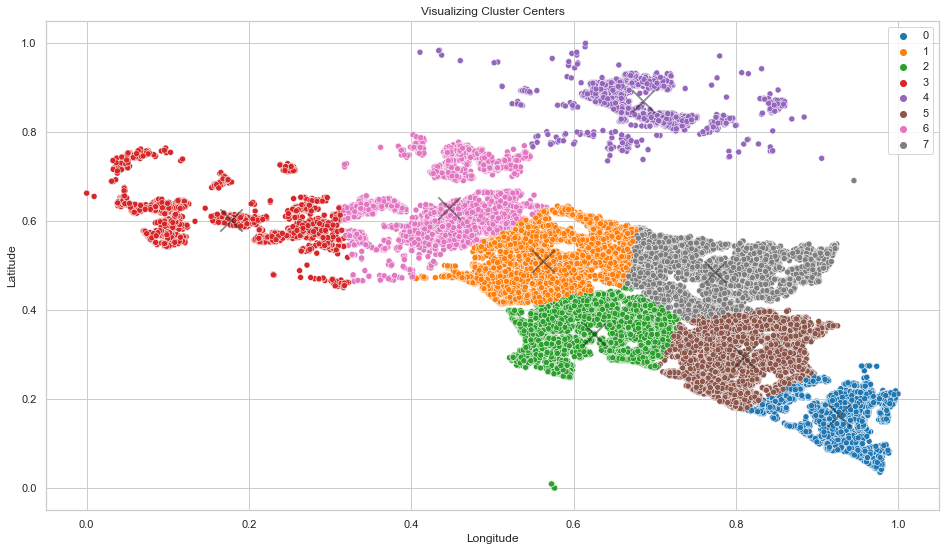

In [27]:
#Plot of clusters with centroids
centroid = train_scaled.groupby('latlong_err_cluster').mean()
centroid

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(x='longitude', y='latitude',
                hue="latlong_err_cluster", 
                palette="tab10",
                data=train_scaled, ax=ax)

sns.scatterplot(x='longitude', y='latitude', 
                color='k', marker='x', s=500,
                data=centroid, ax=ax, alpha=.5)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing Cluster Centers')
plt.show()

In [28]:
# Fit K-Means (just on train, again!)
X = train_scaled[['latitude', 'longitude', 'abs_logerr']]
kmeans = KMeans(n_clusters=200)
kmeans.fit(X)

train_scaled['latlong_err_cluster'] = kmeans.predict(X)
train_scaled.head()

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   
25714        0.125         0.2                      0.096715  0.564669   
21340        0.125         0.3                      0.193824  0.626706   
46673        0.000         0.2                      0.101971  0.326450   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490    0.003760   
66765   0.594425   0.224638           0.027425  0.585111    0.011750   
25714   0.463232   0.688406           0.062036  0.577882    0.000749   
21340   0.377168   0.623188           0.052018  0.575085    0.005586   
46673   0.557556   0.543478           0.061563  0.588555    0.017706   

       latlong_err_cluster  
28420                  149  
66765                  121  
25714                  107  
21340                  115  
46673                   87

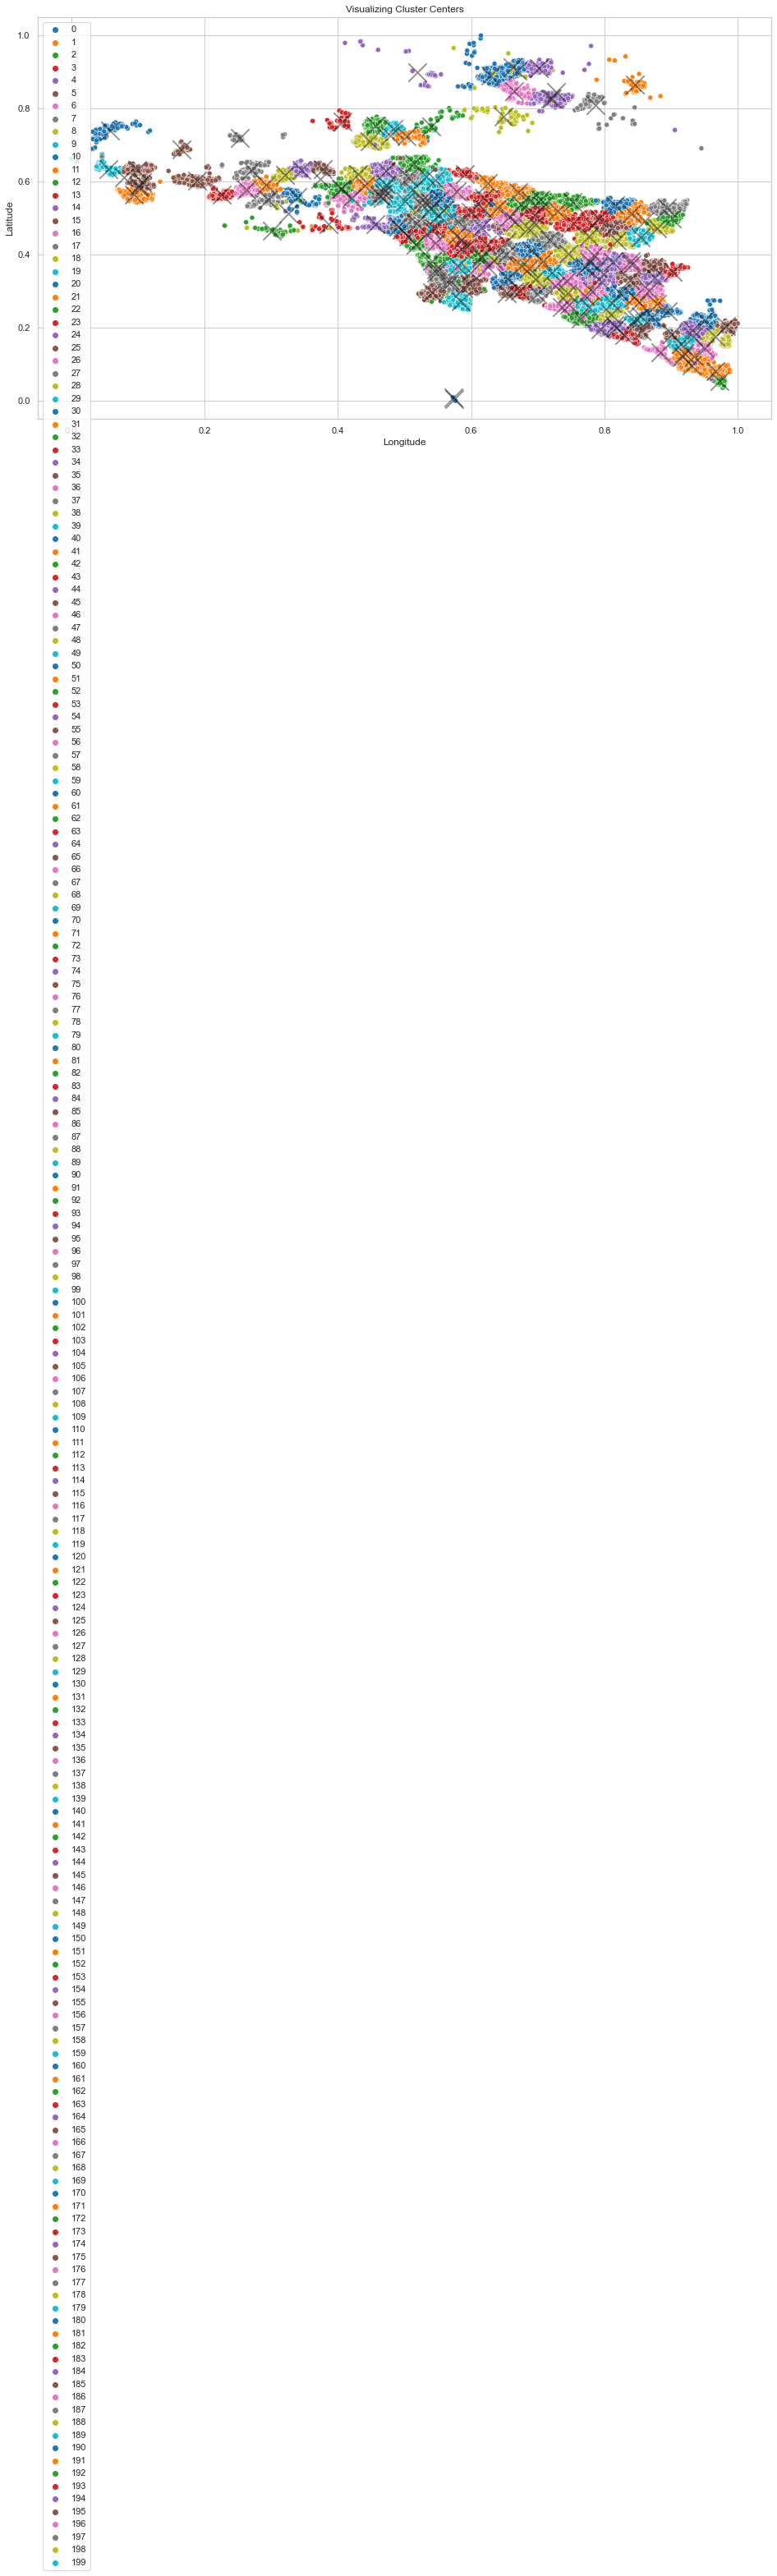

In [29]:
#Plot of clusters with centroids
centroid = train_scaled.groupby('latlong_err_cluster').mean()
centroid

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(x='longitude', y='latitude',
                hue="latlong_err_cluster", 
                palette="tab10",
                data=train_scaled, ax=ax)

sns.scatterplot(x='longitude', y='latitude', 
                color='k', marker='x', s=500,
                data=centroid, ax=ax, alpha=.5)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing Cluster Centers')
plt.show()

In [30]:
# Fit K-Means (just on train, again!)
X = train_scaled[['latitude', 'longitude', 'abs_logerr']]
kmeans = KMeans(n_clusters=1000)
kmeans.fit(X)

train_scaled['latlong_err_cluster'] = kmeans.predict(X)
train_scaled.head()

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   
25714        0.125         0.2                      0.096715  0.564669   
21340        0.125         0.3                      0.193824  0.626706   
46673        0.000         0.2                      0.101971  0.326450   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490    0.003760   
66765   0.594425   0.224638           0.027425  0.585111    0.011750   
25714   0.463232   0.688406           0.062036  0.577882    0.000749   
21340   0.377168   0.623188           0.052018  0.575085    0.005586   
46673   0.557556   0.543478           0.061563  0.588555    0.017706   

       latlong_err_cluster  
28420                  236  
66765                  154  
25714                  335  
21340                  173  
46673                    6

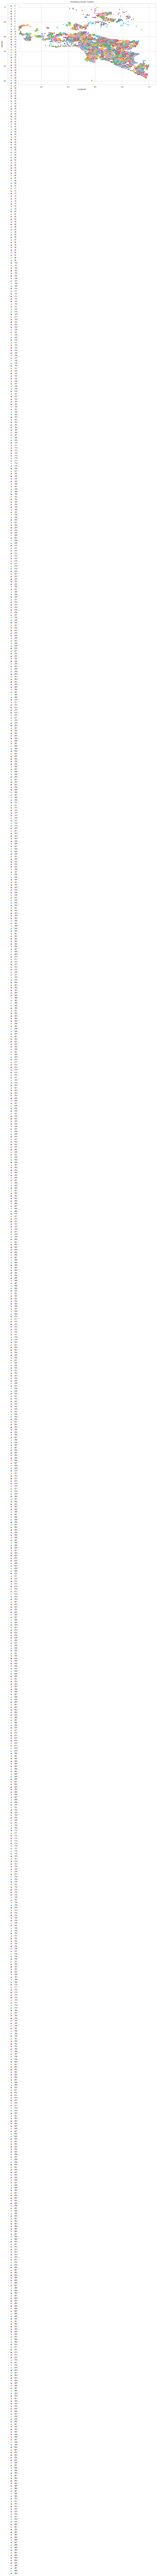

In [31]:
#Plot of clusters with centroids
centroid = train_scaled.groupby('latlong_err_cluster').mean()
centroid

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(x='longitude', y='latitude',
                hue="latlong_err_cluster",
                palette="tab10", 
                data=train_scaled, ax=ax)

# sns.scatterplot(x='longitude', y='latitude', 
#                 color='k', marker='x', s=500,
#                 data=centroid, ax=ax, alpha=.5)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing Cluster Centers')
plt.show()

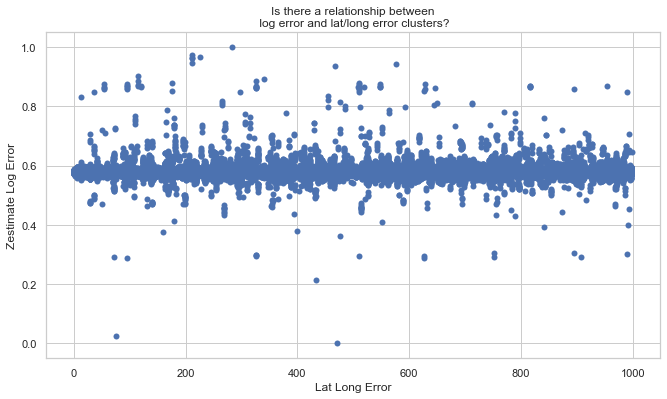

In [32]:
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="latlong_err_cluster", y="logerror",
                sizes=(1, 8), linewidth=0,
                data=train_scaled, ax=ax)
plt.title('Is there a relationship between\n log error and lat/long error clusters?')
plt.xlabel('Lat Long Error')
plt.ylabel('Zestimate Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

##### Findings:
- Clustering by latitude, longitude, and absolute error does not seem to produce any usable results with a small k value due to Lat/long overpowering logerror. At much higher k values the clusters seem to provide better fidelity around error. The issue is how to best encode the clusters around lat/long locations. More time would be needed. 

#### Cluster by Home Value and Size (Square Feet)
- An attempt to try something different

In [33]:
train_scaled.head(3)

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   
25714        0.125         0.2                      0.096715  0.564669   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490    0.003760   
66765   0.594425   0.224638           0.027425  0.585111    0.011750   
25714   0.463232   0.688406           0.062036  0.577882    0.000749   

       latlong_err_cluster  
28420                  236  
66765                  154  
25714                  335

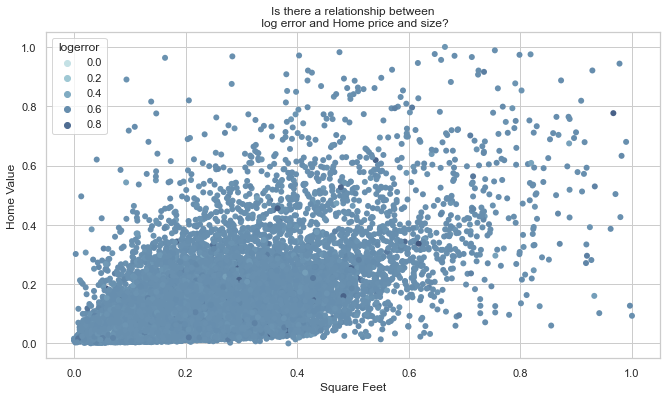

In [34]:
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="calculatedfinishedsquarefeet", y="taxvaluedollarcnt", hue='logerror',
                palette="ch:r=-.2,d=.3", sizes=(1, 8), linewidth=0,
                data=train_scaled, ax=ax)
plt.title('Is there a relationship between\n log error and Home price and size?')
plt.xlabel('Square Feet')
plt.ylabel('Home Value')
ax.xaxis.set_major_formatter('{:.1f}'.format)
plt.show()

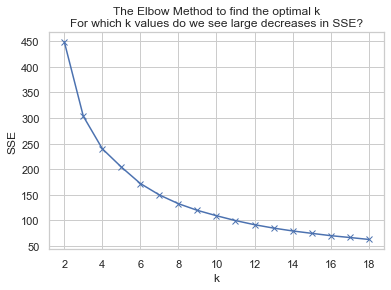

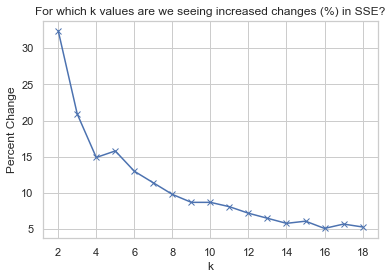

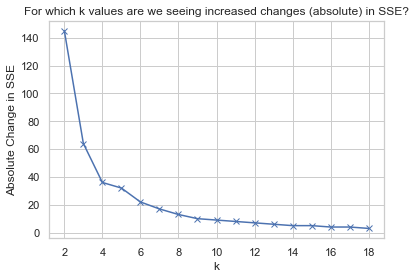

k         sse  delta  pct_delta
0    2  448.803619  145.0       32.4
1    3  303.372016   64.0       20.9
2    4  239.865279   36.0       14.9
3    5  204.203400   32.0       15.8
4    6  172.033981   22.0       13.0
5    7  149.748788   17.0       11.4
6    8  132.662345   13.0        9.8
7    9  119.644235   10.0        8.7
8   10  109.197768    9.0        8.7
9   11   99.727337    8.0        8.1
10  12   91.692732    7.0        7.2
11  13   85.061359    6.0        6.5
12  14   79.510187    5.0        5.8
13  15   74.860988    5.0        6.1
14  16   70.309113    4.0        5.1
15  17   66.741067    4.0        5.7
16  18   62.960414    3.0        5.3

In [35]:
cluster_vars = ['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']
cluster_name = 'size_value'
k_range = range(2,20)

k_comparisons_df = find_k(train_scaled, cluster_vars, k_range)
k_comparisons_df

In [36]:
# Fit K-Means (just on train, again!)
X = train_scaled[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

train_scaled['home_size_value'] = kmeans.predict(X)
train_scaled.head(2)

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490     0.00376   
66765   0.594425   0.224638           0.027425  0.585111     0.01175   

       latlong_err_cluster  home_size_value  
28420                  236                0  
66765                  154                0

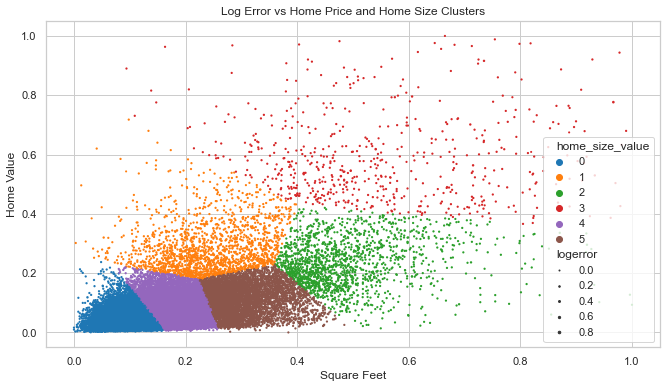

In [147]:
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="calculatedfinishedsquarefeet", y="taxvaluedollarcnt", hue='home_size_value', size='logerror',
                palette="tab10", sizes=(1, 8), linewidth=0,
                data=train_scaled, ax=ax)
plt.title('Log Error vs Home Price and Home Size Clusters')
plt.xlabel('Square Feet')
plt.ylabel('Home Value')
ax.xaxis.set_major_formatter('{:.1f}'.format)
plt.show()

In [139]:
# Average logerror by cluster:
train_scaled.groupby('home_size_value').logerror.mean()

home_size_value
0    0.580042
1    0.579759
2    0.583256
3    0.583920
4    0.579973
5    0.581836
Name: logerror, dtype: float64

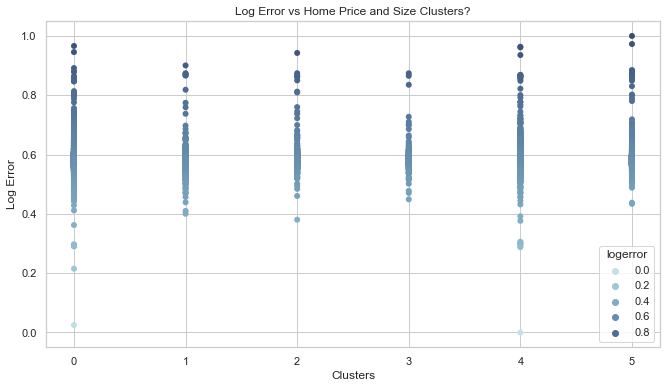

In [38]:
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="home_size_value", y="logerror", hue='logerror',
                palette="ch:r=-.2,d=.3", sizes=(1, 8), linewidth=0,
                data=train_scaled, ax=ax)
plt.title('Log Error vs Home Price and Size Clusters?')
plt.xlabel('Clusters')
plt.ylabel('Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

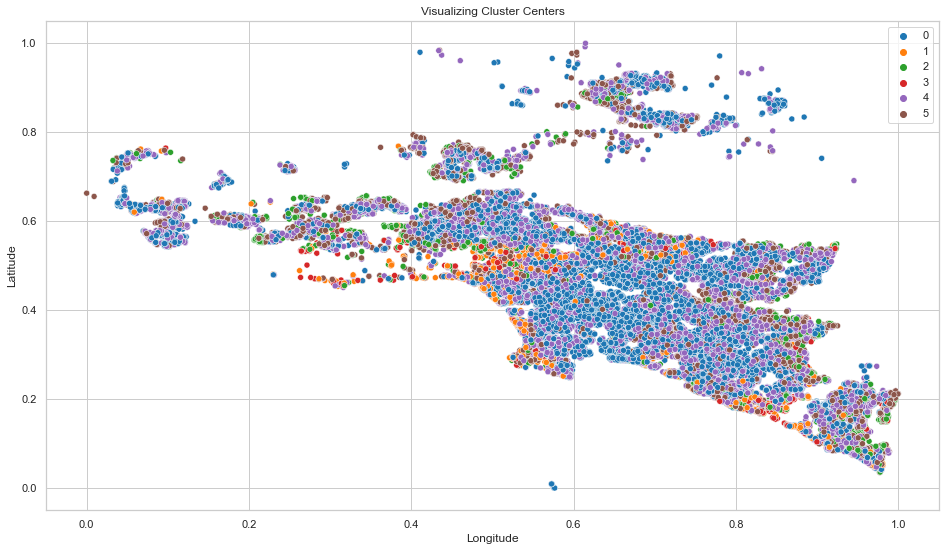

In [39]:
#Plot of clusters with centroids
centroid = train_scaled.groupby('home_size_value').mean()
centroid

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(x='longitude', y='latitude',
                hue="home_size_value",
                palette="tab10", 
                data=train_scaled, ax=ax)

# sns.scatterplot(x='longitude', y='latitude', 
#                 color='k', marker='x', s=500,
#                 data=centroid, ax=ax, alpha=.5)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing Cluster Centers')
plt.show()

##### Findings:
- Clustering by home size (calculatedfinishedsquarefeet) and home value (taxvaluedollarcnt) did not produce any results that would further explain logerror trends. The average logerror by cluster was nearly the same in all cases. 

#### Clustering with Lat/Long and Home Value

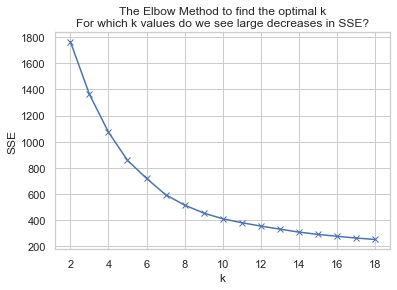

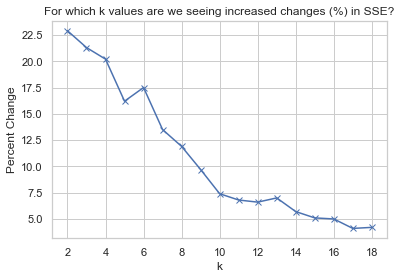

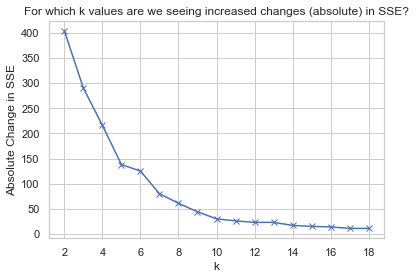

k          sse  delta  pct_delta
0    2  1766.046960  404.0       22.9
1    3  1362.336997  290.0       21.3
2    4  1072.231310  216.0       20.2
3    5   855.869857  138.0       16.2
4    6   717.568328  125.0       17.5
5    7   592.236114   80.0       13.5
6    8   512.459574   61.0       11.9
7    9   451.549443   44.0        9.7
8   10   407.572316   30.0        7.4
9   11   377.294171   26.0        6.8
10  12   351.549700   23.0        6.6
11  13   328.200079   23.0        7.0
12  14   305.277648   17.0        5.7
13  15   287.822632   15.0        5.1
14  16   273.226869   14.0        5.0
15  17   259.665714   11.0        4.1
16  18   249.009094   11.0        4.2

In [40]:
cluster_vars = ['latitude', 'longitude', 'taxvaluedollarcnt']
cluster_name = 'latlong_price_cluster'
k_range = range(2,20)

k_comparisons_df = find_k(train_scaled, cluster_vars, k_range)
k_comparisons_df

In [41]:
# Fit K-Means (just on train, again)
X = train_scaled[['latitude', 'longitude', 'taxvaluedollarcnt']]
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

train_scaled['latlong_price_cluster'] = kmeans.predict(X)
train_scaled.head(2)

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490     0.00376   
66765   0.594425   0.224638           0.027425  0.585111     0.01175   

       latlong_err_cluster  home_size_value  latlong_price_cluster  
28420                  236                0                      6  
66765                  154                0                      2

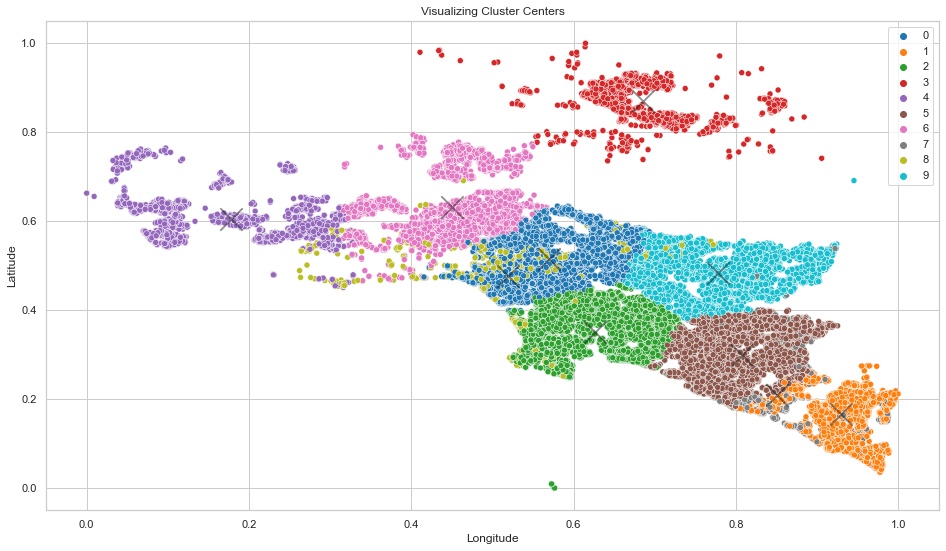

In [42]:
#Plot of clusters with centroids
centroid = train_scaled.groupby('latlong_price_cluster').mean()
centroid

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(x='longitude', y='latitude',
                hue="latlong_price_cluster",
                palette="tab10", 
                data=train_scaled, ax=ax)

sns.scatterplot(x='longitude', y='latitude', 
                color='k', marker='x', s=500,
                data=centroid, ax=ax, alpha=.5)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing Cluster Centers')
plt.show()

In [148]:
# Average logerror by cluster:
train_scaled.groupby('latlong_price_cluster').logerror.mean()

latlong_price_cluster
0    0.578725
1    0.581112
2    0.580261
3    0.580388
4    0.580434
5    0.580812
6    0.580682
7    0.583916
8    0.580535
9    0.580946
Name: logerror, dtype: float64

##### Findings: 
- There may be potential in exploring this further, but I ran into the same issue as before with lat/long, where the number of clusters would need to be quite high for this to be useful. With k=10 there is not much difference between average logerror per cluster.

#### Cluster on Error
- I am not sure if this is allowed, since depending on how it is implimented you could be introducing data leakage, but the only clusters I could visible recognize was from the logerror itself. 
- So, below is an attempt to cluster by logerror and then determine the top drivers of the error within that cluster.

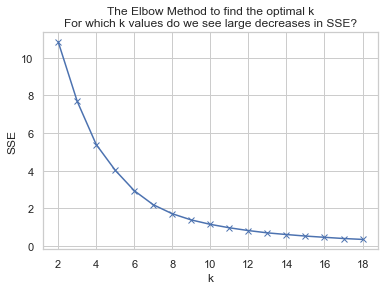

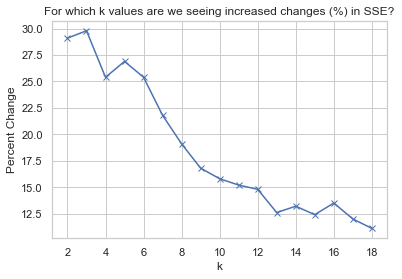

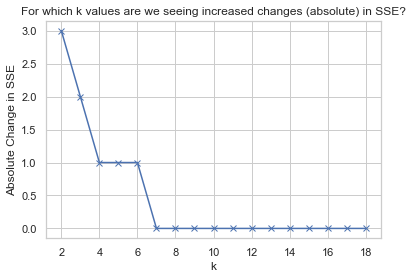

k        sse  delta  pct_delta
0    2  10.839806    3.0       29.1
1    3   7.681041    2.0       29.8
2    4   5.389609    1.0       25.4
3    5   4.022909    1.0       26.9
4    6   2.940210    1.0       25.4
5    7   2.194660    0.0       21.8
6    8   1.716025    0.0       19.1
7    9   1.388138    0.0       16.8
8   10   1.154688    0.0       15.8
9   11   0.972715    0.0       15.2
10  12   0.824919    0.0       14.8
11  13   0.703191    0.0       12.6
12  14   0.614906    0.0       13.2
13  15   0.533799    0.0       12.4
14  16   0.467424    0.0       13.5
15  17   0.404235    0.0       12.0
16  18   0.355732    0.0       11.1

In [43]:
cluster_vars = ['logerror']
cluster_name = 'logerror_cluster'
k_range = range(2,20)

k_comparisons_df = find_k(train_scaled, cluster_vars, k_range)
k_comparisons_df

##### Findings:
- Initially I used k=7 based on the 'elbow' in the charts above; however, after further graphing of the clusters I ultimately went with a k=5.

In [98]:
# Fit K-Means (just on train, again)
X = train_scaled[['logerror']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

train_scaled['logerror_cluster'] = kmeans.predict(X)
train_scaled.head(2)

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490     0.00376   
66765   0.594425   0.224638           0.027425  0.585111     0.01175   

       latlong_err_cluster  home_size_value  latlong_price_cluster  \
28420                  236                0                      6   
66765                  154                0                      2   

       logerror_cluster  
28420                 3  
66765                 3

##### Green and Purple represent the highest error

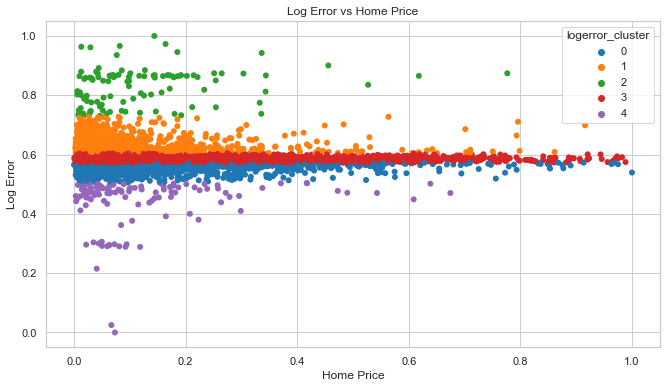

In [141]:
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="taxvaluedollarcnt", y="logerror", hue='logerror_cluster',
                palette="tab10", sizes=(1, 8), linewidth=0,
                data=train_scaled, ax=ax)
plt.title('Log Error vs Home Price')
plt.xlabel('Home Price')
plt.ylabel('Log Error')
ax.xaxis.set_major_formatter('{:.1f}'.format)
plt.show()

In [142]:
# Average logerror per cluster:
train_scaled.groupby('logerror_cluster').logerror.mean()

logerror_cluster
0    0.565065
1    0.629155
2    0.830010
3    0.581169
4    0.444163
Name: logerror, dtype: float64

##### More plotting using lat/long

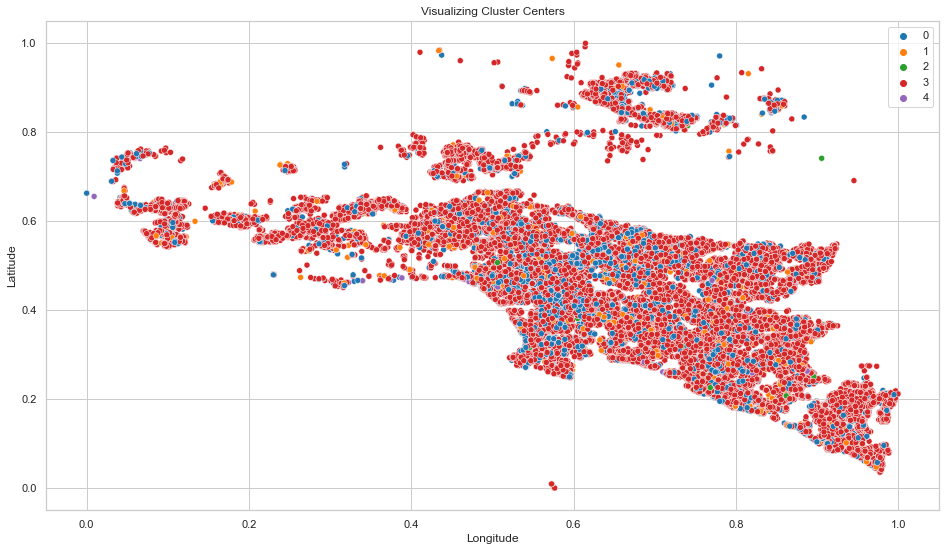

In [149]:
#Plot of clusters with centroids
centroid = train_scaled.groupby('home_size_value').mean()
centroid

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(16, 9))

sns.scatterplot(x='longitude', y='latitude',
                hue="logerror_cluster",
                palette="tab10", 
                data=train_scaled, ax=ax)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing Cluster Centers')
plt.show()

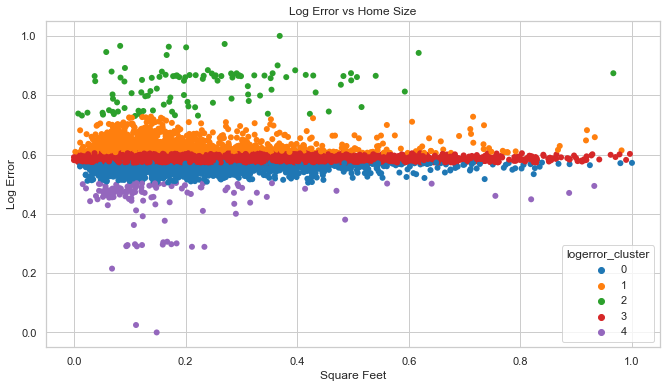

In [101]:
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="calculatedfinishedsquarefeet", y="logerror", hue='logerror_cluster',
                palette="tab10", sizes=(1, 8), linewidth=0,
                data=train_scaled, ax=ax)
plt.title('Log Error vs Home Size')
plt.xlabel('Square Feet')
plt.ylabel('Log Error')
ax.xaxis.set_major_formatter('{:.1f}'.format)
plt.show()

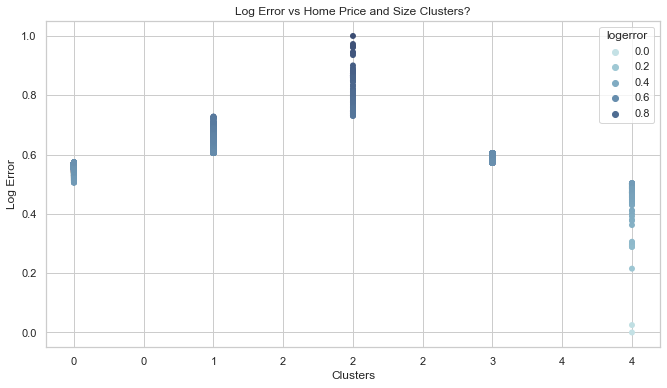

In [102]:
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="logerror_cluster", y="logerror", hue='logerror',
                palette="ch:r=-.2,d=.3", sizes=(1, 8), linewidth=0,
                data=train_scaled, ax=ax)
plt.title('Log Error vs Home Price and Size Clusters')
plt.xlabel('Clusters')
plt.ylabel('Log Error')
ax.xaxis.set_major_formatter('{:.0f}'.format)
plt.show()

##### Findings:
- Clustering by logerror, not surprisingly, created clusters with significantly different log error. These clusters if encoded in a manner that did not data leak information into validate and test could be used to better predict Zestimate error.

## Feature Selection Based on Clusters

##### Split into 5 Separate Data Frames based on logerror clusters:

In [103]:
train_scaled.head(2)

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
28420        0.125         0.1                      0.074901  0.573464   
66765        0.000         0.1                      0.147043  0.441294   

       longitude  yearbuilt  taxvaluedollarcnt  logerror  abs_logerr  \
28420   0.502856   0.826087           0.028647  0.580490     0.00376   
66765   0.594425   0.224638           0.027425  0.585111     0.01175   

       latlong_err_cluster  home_size_value  latlong_price_cluster  \
28420                  236                0                      6   
66765                  154                0                      2   

       logerror_cluster  
28420                 3  
66765                 3

In [104]:
# Dropping columns that won't be used in modeling:
columns_to_drop = ['abs_logerr', 'latlong_err_cluster', 'latlong_price_cluster', 'logerror_cluster', 'home_size_value']

# Creation of 5 subsets of train dataframe based on logerror clusters:
# Also, dropping logerror cluster column since it won't be passed to validte or test.
le_middle = train_scaled[train_scaled.logerror_cluster == 3].drop(columns=columns_to_drop)
le_upper1 = train_scaled[train_scaled.logerror_cluster == 1].drop(columns=columns_to_drop)
le_lower_minus2 = train_scaled[train_scaled.logerror_cluster == 4].drop(columns=columns_to_drop)
le_upper2 = train_scaled[train_scaled.logerror_cluster == 2].drop(columns=columns_to_drop)
le_lower_minus1 = train_scaled[train_scaled.logerror_cluster == 0].drop(columns=columns_to_drop)

In [105]:
# Function to create X_train and y_train for each of the 5 sub dataframes
def xy(le_df):
    X = le_df.drop(columns=['logerror'])
    y = le_df.logerror
    return X, y

In [106]:
# Application of the above function:
X2, y2 = xy(le_upper2)
X1, y1 = xy(le_upper1)
X0, y0 = xy(le_middle)
X_1, y_1 = xy(le_lower_minus1)
X_2, y_2 = xy(le_lower_minus2)

In [150]:
# Example to show that the above functions worked
X2.head(2)

bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  latitude  \
35878        0.125         0.2                      0.182523  0.251725   
74201        0.125         0.3                      0.139422  0.319152   

       longitude  yearbuilt  taxvaluedollarcnt  
35878   0.767779   0.615942           0.065631  
74201   0.610719   0.615942           0.020689

##### Determine the best features for each of the 5 sub dataframes:

In [115]:
# Upper Band
ee.rfe_output(X2, y2)

Var  Rank
0                   bathroomcnt     2
1                    bedroomcnt     5
2  calculatedfinishedsquarefeet     1
3                      latitude     3
4                     longitude     6
5                     yearbuilt     4
6             taxvaluedollarcnt     7

In [110]:
# Middle Upper 
ee.rfe_output(X1, y1)

Var  Rank
0                   bathroomcnt     5
1                    bedroomcnt     1
2  calculatedfinishedsquarefeet     3
3                      latitude     4
4                     longitude     2
5                     yearbuilt     7
6             taxvaluedollarcnt     6

In [111]:
# Middle Band
ee.rfe_output(X0, y0)

Var  Rank
0                   bathroomcnt     4
1                    bedroomcnt     3
2  calculatedfinishedsquarefeet     1
3                      latitude     7
4                     longitude     5
5                     yearbuilt     2
6             taxvaluedollarcnt     6

In [112]:
# Middle Lower
ee.rfe_output(X_1, y_1)

Var  Rank
0                   bathroomcnt     5
1                    bedroomcnt     2
2  calculatedfinishedsquarefeet     1
3                      latitude     6
4                     longitude     7
5                     yearbuilt     3
6             taxvaluedollarcnt     4

In [113]:
# Lower Band
ee.rfe_output(X_2, y_2)

Var  Rank
0                   bathroomcnt     2
1                    bedroomcnt     1
2  calculatedfinishedsquarefeet     5
3                      latitude     6
4                     longitude     7
5                     yearbuilt     3
6             taxvaluedollarcnt     4

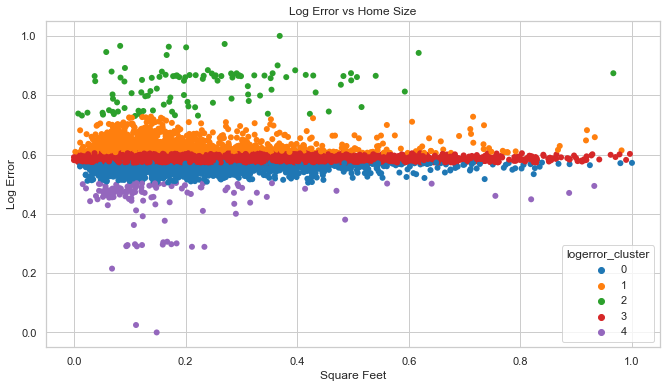

In [116]:
f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(x="calculatedfinishedsquarefeet", y="logerror", hue='logerror_cluster',
                palette="tab10", sizes=(1, 8), linewidth=0,
                data=train_scaled, ax=ax)
plt.title('Log Error vs Home Size')
plt.xlabel('Square Feet')
plt.ylabel('Log Error')
ax.xaxis.set_major_formatter('{:.1f}'.format)
plt.show()

## Cluster Conclusion

### Top Two Drivers of Zestimate Error for Each Train Subset based on Error Clustering:
- Upper Error Clusters: **calculatedfinishedsquarefeet, bathroomcnt**
- U. Mid Error Cluster: **bedroomcnt, longitude**
- Middle Error Cluster: **calculatedfinishedsquarefeet, yearbuilt**
- L. Mid Error Cluster: **calculatedfinishedsquarefeet, bedroomcnt**
- Lower Error Clusters: **bedroomcnt, bathroomcnt**

##### Takeaways:
- Home Square footage and the number of bedrooms and bathrooms are the most common drivers of error in the Zestimate.
- Square footage and bathroom count were the biggest drivers for overestimation of home value.
- Bedroom and bathroom count were the biggest drivers for underestimation of home value.

## Regression Models Using Clusters:
- Producing linear regression models for each of the five subset of train to see if they produce a better prediction for validate.

In [123]:
# Function for Visual representation of the compare chart:
def plot_compare(compare):
    f, ax = plt.subplots(figsize=(6, 6))
    sns.set_color_codes("muted")
    sns.barplot(x="model", y="RMSE Validate", data=compare,
                label="Validate", color="b")
    sns.set_color_codes("pastel")
    sns.barplot(x="model", y="RMSE Train", data=compare,
                label="Train", color="b")
    ax.legend(ncol=2, loc="lower right", frameon=True)
    plt.ylabel('RMSE')
    plt.xticks(rotation = 45)
    sns.despine(left=True, bottom=True)

In [121]:
# Model Using the Upper Band for train
compare2 = zm.model_compare(X2, y2, X_validate, y_validate)
compare2

model  RMSE Train  RMSE Validate  r^2 Validate
0  Baseline (mean)    0.063457       0.020839  0.000000e+00
1    OLS Regressor    0.058285       0.239987 -9.938203e-01
2   Lasso: Alpha 1    0.063457       0.250749 -2.220446e-16
3       GLM Normal    0.058291       0.240067 -9.872573e-01
4      GLM Poisson    0.058340       0.240038 -9.703616e-01
5  Polynomial 2deg    0.079079       0.250457 -3.688651e+01
6  Polynomial 3deg    0.000000       1.354910 -4.174301e+03

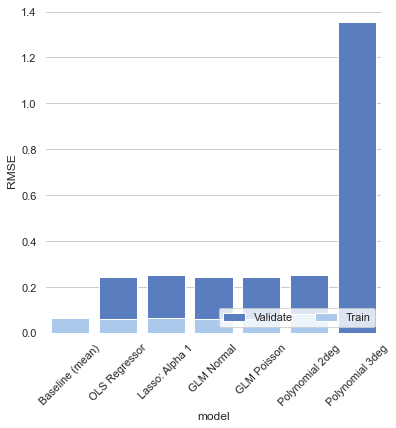

In [124]:
plot_compare(compare2)

##### Takeaway: Upper Band is Not a great predictor for Validate

In [125]:
# Model Using the Upper Middle Band for train
compare1 = zm.model_compare(X1, y1, X_validate, y_validate)
compare1

model  RMSE Train  RMSE Validate  r^2 Validate
0  Baseline (mean)    0.025066       0.020839  0.000000e+00
1    OLS Regressor    0.024955       0.053337 -1.433730e-02
2   Lasso: Alpha 1    0.025066       0.053271 -2.220446e-16
3       GLM Normal    0.025001       0.053353 -6.191946e-03
4      GLM Poisson    0.025001       0.053354 -6.199929e-03
5  Polynomial 2deg    0.024594       0.053104 -5.631879e-02
6  Polynomial 3deg    0.023555       0.053646 -2.618891e-01

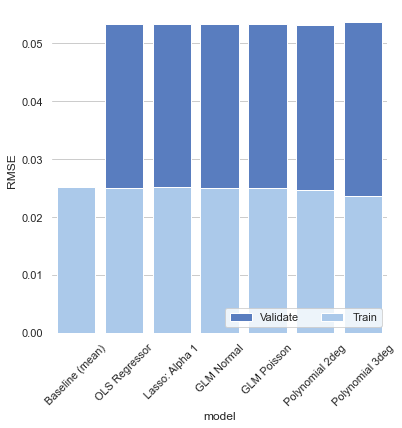

In [126]:
plot_compare(compare1)

##### Takeaway: Upper Middle Band is better but still Not a great predictor for Validate

In [127]:
# Model Using the Middle Band for train
compare0 = zm.model_compare(X0, y0, X_validate, y_validate)
compare0

model  RMSE Train  RMSE Validate  r^2 Validate
0  Baseline (mean)    0.005683       0.020839      0.000000
1    OLS Regressor    0.005606       0.020888     -0.001874
2   Lasso: Alpha 1    0.005683       0.020865      0.000000
3       GLM Normal    0.005683       0.020865      0.000000
4      GLM Poisson    0.005683       0.020865      0.000000
5  Polynomial 2deg    0.005587       0.020881     -0.001160
6  Polynomial 3deg    0.005561       0.020887     -0.001720

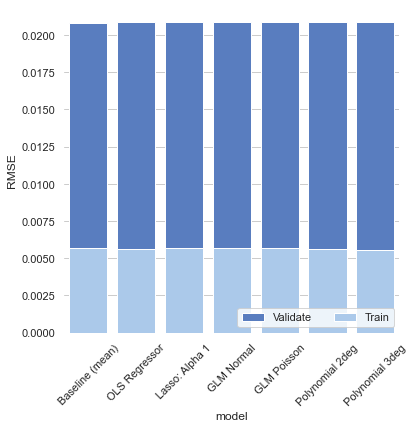

In [128]:
plot_compare(compare0)

##### Takeaway: The middle Band is the best preidictor, but still Not a great predictor for Validate

In [129]:
# Model Using the Lower Middle Band for train
compare_1 = zm.model_compare(X_1, y_1, X_validate, y_validate)
compare_1

model  RMSE Train  RMSE Validate  r^2 Validate
0  Baseline (mean)    0.010200       0.020839  0.000000e+00
1    OLS Regressor    0.009954       0.025492 -8.710619e-03
2   Lasso: Alpha 1    0.010200       0.025714 -2.220446e-16
3       GLM Normal    0.010016       0.025506 -7.829075e-03
4      GLM Poisson    0.010008       0.025556 -7.850223e-03
5  Polynomial 2deg    0.009890       0.025463 -1.128920e-02
6  Polynomial 3deg    0.009740       0.025460 -1.773824e-02

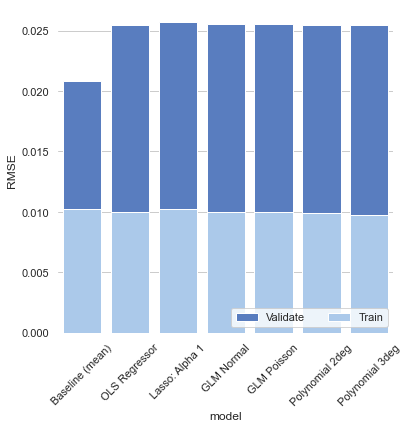

In [130]:
plot_compare(compare_1)

##### Takeaway: Getting worse again

In [131]:
# Model Using the Lower Band for train
compare_2 = zm.model_compare(X_2, y_2, X_validate, y_validate)
compare_2

model  RMSE Train  RMSE Validate   r^2 Validate
0  Baseline (mean)    0.084570       0.020839       0.000000
1    OLS Regressor    0.078810       0.163774      -2.065603
2   Lasso: Alpha 1    0.084570       0.137553       0.000000
3       GLM Normal    0.078811       0.163798      -2.055904
4      GLM Poisson    0.079205       0.163167      -1.949940
5  Polynomial 2deg    0.080482       0.195635     -41.018729
6  Polynomial 3deg    0.002132      10.980706 -268982.126422

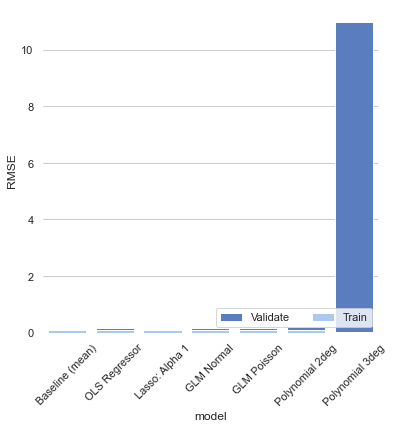

In [132]:
plot_compare(compare_2)

##### Takeaway: The lower band is not a great predictor either

## Conclusion:
- Using the clustered dataframe subsets of train, based on legerror bands, did not improve the logerror prediction of validate above simply passing all of the train datafram to the regression models. 

## With more time:
- Create regression models based on the top two features for each of the 5 logerror subsets of train
- Explore applying logerror weights (encoding) based on lat/long at a neighborhood level
- Explore encoding methods
- Explore using sklearn pipline function